In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
from scipy import stats

from sklearn.linear_model import LinearRegression
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import kendalltau, pearsonr, spearmanr
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 10

In [120]:
class CleanStationarize():
    def __init__(self, df):
        self.df = df
        
    def date(self):
        self.df['timestamp'] = self.df['timestamp'].str[0:10]
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'], format='%Y%m%d')
        self.df['timestamp'] = self.df.set_index('timestamp')
        
    def ipl(self):
        for column in self.df:
            self.df[column] = self.df[column].interpolate(method = 'linear', limit_direction = 'both')
    
    def detrend(self):
        for column in self.df:
            days = [i for i in range(0,len(self.df[column]))]
            days = np.reshape(days, (len(days), 1))
            model = LinearRegression()
            col_values = self.df[column]
            model.fit(days, self.df[column])
            col_trend = model.predict(days)
            detrended_col_values = [col_values[i] - col_trend[i] for i in range(0, len(self.df[column]))]
            self.df[column] = detrended_col_values
    
    def diff(self):
        for column in self.df:
            self.df[column] = self.df[column].diff(periods=-1)
            


In [121]:
class LaggedRelationship():
    def __init__(self, df, lag_start, lag_end, feature, target, resample):
        self.df = df
        self.lag_start = lag_start
        self.lag_end = lag_end
        self.feature = feature 
        self.target = target
        self.resample = resample
    
    def lag_cross_corr(self):
        df_temp = pd.DataFrame()
        cc = {}
        for i in range(self.lag_start, self.lag_end):
            df_temp[self.feature] = self.df[self.feature].shift(i)
            df_temp = df_temp.dropna()
            cc[i*self.resample] = df_temp[self.feature].corr(self.df[self.target])
            df_temp[self.feature] = self.df[self.feature]
        return cc
        
    def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]
    
    def lag_cc_pv(self):
        df_temp = pd.DataFrame()
        p_values = {}
        for i in range(self.lag_start, self.lag_end):
            df_temp[self.feature] = self.df[self.feature].shift(i)
            df_temp = df_temp.dropna()
            p_values[i*self.resample] = df_temp[self.feature].corr(self.df[self.target], method=pearsonr_pval)
            df_temp[self.feature] = self.df[self.feature]
        return p_values

In [145]:
def vizualize(dic):
    for i in dic:
        plt.plot(*zip(*sorted(dic[i].items())), label = i, alpha=0.9, marker='o')
    plt.xlabel('Lag: # of days elapsed between 1) Real Yield & 2) Staking Rate data entries', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=16)
    plt.axis([0, 250, -1,1])
    plt.grid(b=True, which='major', color='#999999', linestyle='-')

In [156]:
networks = {}

networks['tezos'] = pd.read_csv(r'tezos_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'], index_col='timestamp', parse_dates=True)
networks['cosmos'] = pd.read_csv(r'cosmos_02072020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)
networks['livepeer'] = pd.read_csv(r'livepeer_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)

cc = {}
for net in networks:
    st = CleanStationarize(networks[net])
    st.ipl()
    st.detrend() 
    st.diff()
    networks[net] = networks[net].resample('D').agg(dict(real_yield='sum', staking_rate='mean'))
    lr = LaggedRelationship(networks[net], 0, 249, 'real_yield', 'staking_rate', 1)
    cc['%s_cc'%net] = lr.lag_cross_corr()
cc

/Users/arjhaz/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/arjhaz/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


{'tezos_cc': {0: -0.9902662493132012,
  1: 0.1658851147475421,
  2: 0.0067486899933212495,
  3: -0.10544346663400166,
  4: -0.022710144117307526,
  5: 0.014781914202786762,
  6: -0.013088827050353755,
  7: 0.008671195501087178,
  8: -0.007242652359503681,
  9: 0.019150816230266394,
  10: 0.040400039953747836,
  11: -0.050026278126200925,
  12: 0.09685593051481839,
  13: -0.046888196010314645,
  14: -0.017696435663536438,
  15: -0.0523546056002138,
  16: 0.028582083828959475,
  17: -0.035346843453714465,
  18: 0.02653807084305983,
  19: -0.023284082118873235,
  20: 0.013947073205455579,
  21: -0.03827374076784229,
  22: -0.06140666031488159,
  23: 0.05255951164520667,
  24: -0.07883775294920316,
  25: -0.036964720672008566,
  26: 0.005488528700049965,
  27: -0.017853304075445206,
  28: 0.00865462582273745,
  29: 0.0017842001993835406,
  30: -0.0593421216072245,
  31: 0.03197310351943147,
  32: -0.019577124020634832,
  33: -0.005705176842229634,
  34: 0.08789520740441091,
  35: 0.0341563

Text(0, 0.5, 'Cross-correlation (Pearson)')

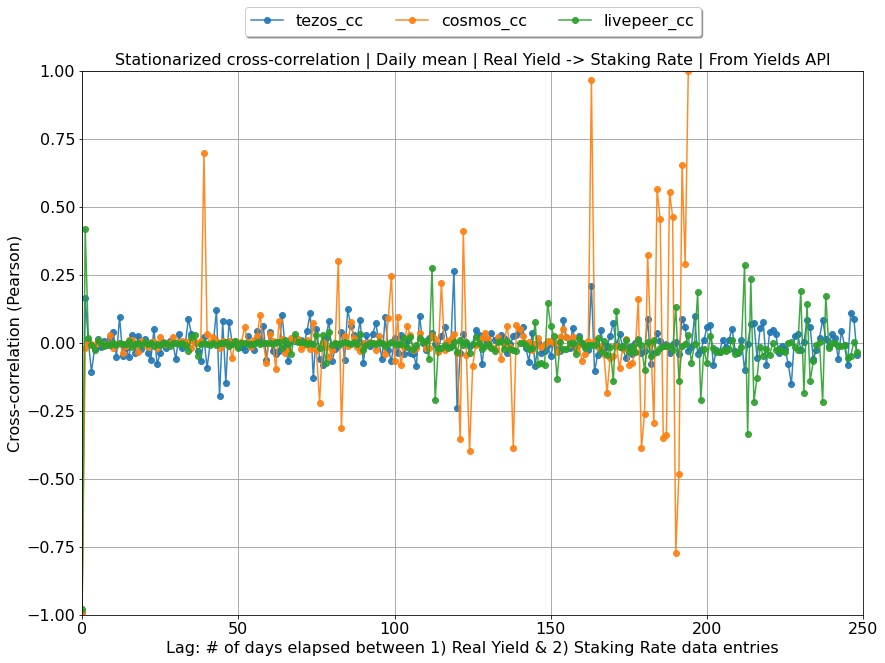

In [157]:
vizualize(cc)
plt.title('Stationarized cross-correlation | Daily mean | Real Yield -> Staking Rate | From Yields API', fontsize=16)
plt.ylabel('Cross-correlation (Pearson)', fontsize=16)

In [148]:
networks = {}

networks['tezos'] = pd.read_csv(r'tezos_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'], index_col='timestamp', parse_dates=True)
networks['cosmos'] = pd.read_csv(r'cosmos_02072020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)
networks['livepeer'] = pd.read_csv(r'livepeer_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)

cc = {}
for net in networks:
    st = CleanStationarize(networks[net])
    st.ipl()
    st.detrend() 
    st.diff()
    networks[net] = networks[net].resample('SMS').agg(dict(real_yield='sum', staking_rate='mean'))
    lr = LaggedRelationship(networks[net], 0, 17, 'real_yield', 'staking_rate', (365/24))
    cc['%s_cc'%net] = lr.lag_cross_corr()

/Users/arjhaz/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/arjhaz/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Text(0, 0.5, 'Cross-correlation (Pearson)')

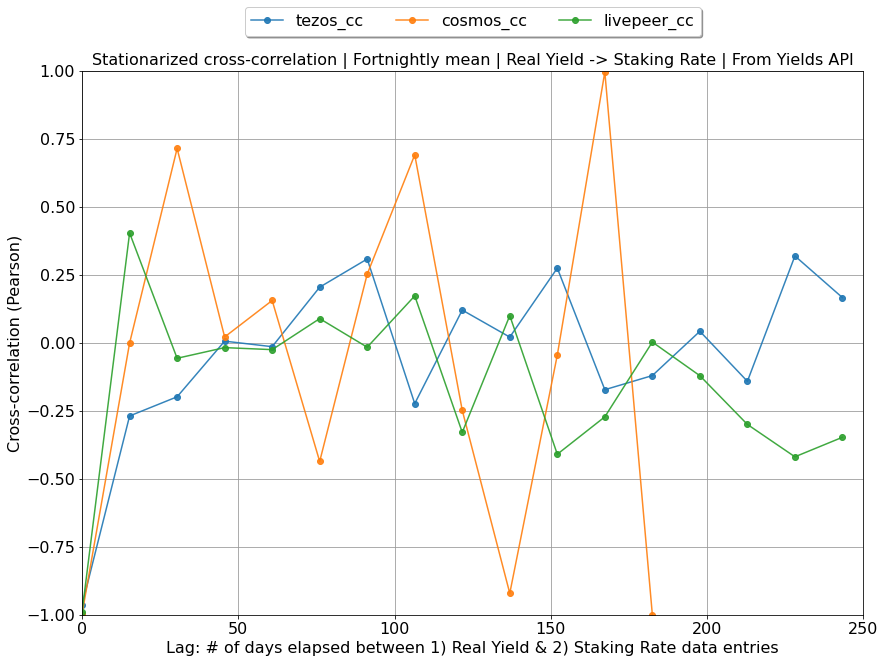

In [149]:
vizualize(cc)
plt.title('Stationarized cross-correlation | Fortnightly mean | Real Yield -> Staking Rate | From Yields API', fontsize=16)
plt.ylabel('Cross-correlation (Pearson)', fontsize=16)

In [150]:
networks = {}

networks['tezos'] = pd.read_csv(r'tezos_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'], index_col='timestamp', parse_dates=True)
networks['cosmos'] = pd.read_csv(r'cosmos_02072020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)
networks['livepeer'] = pd.read_csv(r'livepeer_09142020.csv', usecols=['real_yield', 'staking_rate', 'timestamp'],index_col='timestamp', parse_dates=True)

cc = {}
for net in networks:
    st = CleanStationarize(networks[net])
    st.ipl()
    st.detrend() 
    st.diff()
    networks[net] = networks[net].resample('M').agg(dict(real_yield='sum', staking_rate='mean'))
    lr = LaggedRelationship(networks[net], 0, 9, 'real_yield', 'staking_rate', (365/12))
    cc['%s_cc'%net] = lr.lag_cross_corr()
cc

/Users/arjhaz/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/arjhaz/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


{'tezos_cc': {0.0: -0.9547092609454456,
  30.416666666666668: -0.3549758513448417,
  60.833333333333336: 0.04689973841876198,
  91.25: 0.18885041250260395,
  121.66666666666667: 0.2243042133208797,
  152.08333333333334: 0.094447091779989,
  182.5: -0.30344286755880645,
  212.91666666666669: -0.23914086099974347,
  243.33333333333334: 0.6137566634607208},
 'cosmos_cc': {0.0: -0.9840293829885627,
  30.416666666666668: 0.4881607033050452,
  60.833333333333336: -0.10112404368639089,
  91.25: 0.7961847291051687,
  121.66666666666667: -0.895157692813781,
  152.08333333333334: 0.1913549329024558,
  182.5: -1.0,
  212.91666666666669: nan,
  243.33333333333334: nan},
 'livepeer_cc': {0.0: -0.7998207419750099,
  30.416666666666668: -0.6765712097421908,
  60.833333333333336: -0.3783241461093622,
  91.25: -0.21593394401426025,
  121.66666666666667: -0.1801919568515695,
  152.08333333333334: -0.6725978413663598,
  182.5: -0.6225625712713694,
  212.91666666666669: -0.951377961555828,
  243.333333333

Text(0, 0.5, 'Cross-correlation (Pearson)')

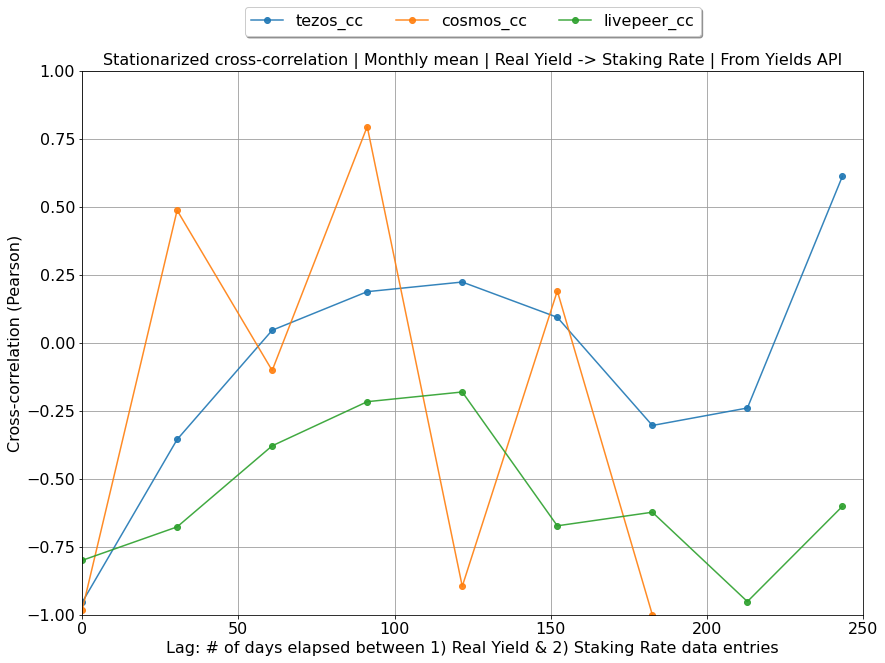

In [151]:
vizualize(cc)
plt.title('Stationarized cross-correlation | Monthly mean | Real Yield -> Staking Rate | From Yields API', fontsize=16)
plt.ylabel('Cross-correlation (Pearson)', fontsize=16)